# Data Preparation

Here in this data preparation jupyter notebook, we will prepare our data that will go into a Convolutional Neural Network model later.

## 0. Setup parameters and load libraries

In [1]:
import glob
import io
import os
import sys

import requests
import tqdm

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import quilt
import rasterio
import rasterio.mask
import rasterio.plot
import shapely.geometry
%matplotlib inline

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Rasterio     :', rasterio.__version__)

Python       : 3.6.6 | packaged by conda-forge | (default, Jul 26 2018, 09:53:17) 
Numpy        : 1.14.5
Rasterio     : 1.0.7


## 1. Get Data!

### Download Low Resolution bed elevation data (e.g. [BEDMAP2](https://doi.org/10.5194/tc-7-375-2013))

In [2]:
url = "http://data.pgc.umn.edu/elev/dem/bedmap2/bedmap2_bed.tif"  #link to BEDMAP2 Bed Elevation GeoTiff
path = "lowres/bedmap2_bed.tif"  #path to download the file to

if not os.path.exists(path=path):
    r = requests.get(url=url, stream=True)
    with open(file=path, mode='wb') as fd:
        for chunk in r.iter_content(chunk_size=1024):
            fd.write(chunk)

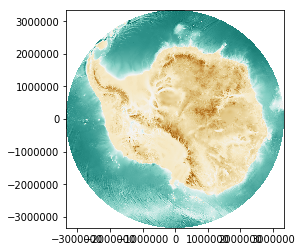

In [3]:
with rasterio.open("lowres/bedmap2_bed.tif") as raster_source:
    rasterio.plot.show(source=raster_source, cmap='BrBG_r')

### Download High Resolution bed elevation data (e.g. some-DEM-name)

In [4]:
url = "http://ramadda.nerc-bas.ac.uk/repository/entry/get/Polar%20Data%20Centre/DOI/Rutford%20Ice%20Stream%20bed%20elevation%20DEM%20from%20radar%20data/bed_WGS84_grid.txt?entryid=synth%3A54757cbe-0b13-4385-8b31-4dfaa1dab55e%3AL2JlZF9XR1M4NF9ncmlkLnR4dA%3D%3D"
path = "highres/bed_WGS84_grid.txt"  #path to download the file to

if not os.path.exists(path=path):
    r = requests.get(url=url, stream=True)
    with open(file=path, mode='wb') as fd:
        for chunk in r.iter_content(chunk_size=1024):
            fd.write(chunk)

### Download miscellaneous data (e.g. [REMA](https://www.pgc.umn.edu/data/rema/))

In [5]:
miscDict = {"misc/REMA_200m_dem_filled.tif": "http://data.pgc.umn.edu/elev/dem/setsm/REMA/mosaic/v1.0/200m/REMA_200m_dem_filled.tif",
            "misc/MEaSUREs_IceFlowSpeed_450m.tif": "http://data.pgc.umn.edu/gis/packages/quantarctica/Quantarctica3/Glaciology/MEaSUREs%20Ice%20Flow%20Velocity/MEaSUREs_IceFlowSpeed_450m.tif"}

for path, url in miscDict.items():
    if not os.path.exists(path=path):
        r = requests.get(url=url, stream=True)
        with open(file=path, mode='wb') as fd:
            for chunk in r.iter_content(chunk_size=1024):
                fd.write(chunk)

## 2. Process high resolution data into grid format

[ASCII Text](https://pdal.io/stages/readers.text.html) ----> [GeoTIFF](https://pdal.io/stages/writers.gdal.html)

In [6]:
# change to highres directory, list all the json pipeline files, run pdal pipeline on each of those files
!cd highres && ls *.json | xargs -n1 pdal pipeline --nostream -i

TODO:
- use Python bindings instead of shell

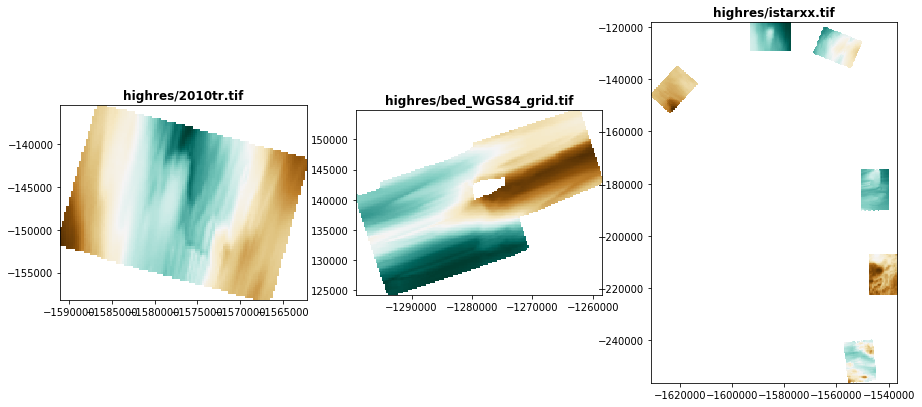

In [7]:
tifs = glob.glob("highres/*.tif")
fig, axarr = plt.subplots(nrows=1+((len(tifs)-1)//3), ncols=3, squeeze=False, figsize=(15,15))

for i, tif in enumerate(tifs):
    with rasterio.open(tif) as raster_source:
        rasterio.plot.show(source=raster_source, cmap='BrBG_r', ax=axarr[i//3,i%3], title=tif)

## 3. Tile data

### Tile High Resolution data

In [8]:
def regular_tile(filepath:str, height:int=32, width:int=32) -> np.ndarray:
    """
    Reads in rasters and tiles them according to a moving window.
    Tiles will be fit to the high resolution dataset bounds.
    """
    
    assert(height==width)  #make sure it's a square!
    array_list = []
    window_bounds = []  #list to store the geographic bounding box of each crop
    
    with rasterio.open(filepath) as dataset:
        print(f'Tiling: {filepath}')
        #Loop along the raster image from top to bottom, and left to right
        for uly in range(0, dataset.shape[0]-width, 4):
            for ulx in range(0, dataset.shape[1]-height, 4):
            
                #Create a cropping window, and get the geographic bounds too
                window = rasterio.windows.Window(col_off=ulx, row_off=uly, width=width, height=height)
                window_bound = rasterio.windows.bounds(window=window, transform=dataset.transform)
                
                #Read the raster according to the crop window
                array = dataset.read(indexes=list(range(1,dataset.count+1)), masked=True, window=window, out_shape=(height,width))
                array = np.rollaxis(a=array, axis=0, start=3)   #change to shape (height, width, 1)
                
                #Check if the raster is a full raster, i.e. no blank/NODATA
                if not array.mask.any():
                    array_list.append(array.data)
                    window_bounds.append(window_bound)
    
    return np.stack(arrays=array_list), window_bounds

In [9]:
h, w = zip(*[regular_tile(filepath=tif) for tif in glob.glob("highres/*.tif")])
hires, window_bounds = np.concatenate(h), np.concatenate(w).tolist()
print(hires.shape, hires.dtype, len(window_bounds))

Tiling: highres/2010tr.tif
Tiling: highres/bed_WGS84_grid.tif
Tiling: highres/istarxx.tif
(371, 32, 32, 1) float32 371


### Show tiles

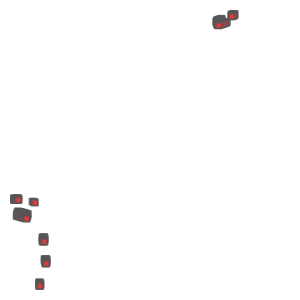

In [10]:
#shapely.geometry.box(*window_bound)
shapely.geometry.MultiPolygon([shapely.geometry.box(*bound) for bound in window_bounds])

### Tile low resolution data

In [11]:
def selective_tile(filepath:str, window_bounds:list) -> np.ndarray:
    """
    Reads in raster and tiles them selectively.
    Tiles will go according to list of window_bounds.
    """
    
    array_list = []
    
    with rasterio.open(filepath) as dataset:
        print(f'Tiling: {filepath}')
        for window_bound in window_bounds:
            window = rasterio.windows.from_bounds(*window_bound, transform=dataset.transform)
        
            #Read the raster according to the crop window
            array = dataset.read(indexes=list(range(1,dataset.count+1)), masked=True, window=window)
            array = np.rollaxis(a=array, axis=0, start=3)   #change to shape (height, width, 1)
    
            assert(not array.mask.any())
            array_list.append(array.data.astype(dtype=np.float32))
    
    return np.stack(arrays=array_list)

In [12]:
lores = selective_tile(filepath="lowres/bedmap2_bed.tif", window_bounds=window_bounds)
print(lores.shape, lores.dtype)

Tiling: lowres/bedmap2_bed.tif
(371, 8, 8, 1) float32


### Tile miscellaneous data

In [13]:
rema = selective_tile(filepath="misc/REMA_200m_dem_filled.tif", window_bounds=window_bounds)
print(rema.shape, rema.dtype)

Tiling: misc/REMA_200m_dem_filled.tif
(371, 40, 40, 1) float32


In [14]:
measuresiceflow = selective_tile(filepath="misc/MEaSUREs_IceFlowSpeed_450m.tif", window_bounds=window_bounds)
print(measuresiceflow.shape, measuresiceflow.dtype)

Tiling: misc/MEaSUREs_IceFlowSpeed_450m.tif
(371, 17, 17, 1) float32


## 4. Save the arrays

We'll save the numpy arrays to the filesystem first.
We label inputs as X (low resolution bed DEMs) and W (miscellaneous).
Groundtruth high resolution bed DEMs are labelled as Y.

Also, we'll serve the data up on the web using:
- [Quilt](https://quiltdata.com/) - Python data versioning
- [Dat](https://datproject.org/) - Distributed data sharing (TODO)

In [15]:
os.makedirs(name="model/train", exist_ok=True)
np.save(file="model/train/W1_data.npy", arr=rema)
np.save(file="model/train/W2_data.npy", arr=measuresiceflow)
np.save(file="model/train/X_data.npy", arr=lores)
np.save(file="model/train/Y_data.npy", arr=hires)

### Quilt

Login -> Build -> Push

In [16]:
quilt.login()

Launching a web browser...
If that didn't work, please visit the following URL: https://pkg.quiltdata.com/login



Enter the code from the webpage:  eyJpZCI6ICIyOWI4YzUyNS1lZmM1LTQ5NTItOGQ4Yy03NzQyYTg1YmI1MmEiLCAiY29kZSI6ICJjZmUwNTQ1OS1iNjc5LTRmMzQtOWZiOC0zNjk1MDhlZmU4YjEifQ==


In [17]:
quilt.build(package='weiji14/deepbedmap/model/train/W1_data', path=rema)
quilt.build(package='weiji14/deepbedmap/model/train/W2_data', path=measuresiceflow)
quilt.build(package='weiji14/deepbedmap/model/train/X_data', path=lores)
quilt.build(package='weiji14/deepbedmap/model/train/Y_data', path=hires)

In [18]:
quilt.push(package='weiji14/deepbedmap', is_public=True)

Fetching upload URLs from the registry...


  0%|          | 0.00/4.42M [00:00<?, ?B/s]

Uploading 4 fragments (4418380 bytes)...


 39%|███▊      | 1.70M/4.42M [00:01<00:35, 76.2kB/s]

Fragment eca3d10c0de5c1e97a84b576ff35220a012719e786372067c026b7c0506bdfbd already uploaded; skipping.
Fragment 62caba5a388542f34014fbcb76c361b2c55a9ea3f54c81e3e1090315177336b4 already uploaded; skipping.
Fragment 57c2344940a147a198098df7bb1c36d08e0c07a7a12e7cb2fc33c433a2d1fdd0 already uploaded; skipping.


100%|██████████| 4.42M/4.42M [00:02<00:00, 1.70MB/s]


Uploading package metadata...
Updating the 'latest' tag...
Push complete. weiji14/deepbedmap is live:
https://quiltdata.com/package/weiji14/deepbedmap
